# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [1]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


## 2. Configuration

In [2]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.10          # Binary Label Noise probability
disc_factor = np.pi/2    # Similarity of Y_sen to X  np.pi/4 
n_samples = 2000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                  # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd_example = 1                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= -1
lmd_end= 4
lmd_interval = np.linspace(lmd_start, lmd_end, 40)
symmetric_fairness = False

mean_pairs = [
    (np.array([0.5, 0.5]),  np.array([0.5, -0.5])),
    (np.array([1.5, 1.5]),  np.array([-1.5, -1.5])),
    (np.array([5., 5.]),  np.array([-5., -5.])),
]

dataset_titles = [
    "Low Class Separation",
    "Moderate Class Separation",
    "High Class Separation"
]

pareto_titles = [
    "",
    "",
    ""
]

## 3. Data Generation

[0.5 0.5]
iter: 0 acc p: 0.6125
iter: 0 acc f: 0.5525
[1.5 1.5]
iter: 1 acc p: 0.8216666666666667
iter: 1 acc f: 0.7458333333333333
[5. 5.]
iter: 2 acc p: 0.9983333333333333
iter: 2 acc f: 0.9475


Text(0.73, 0.02, '(ii)')

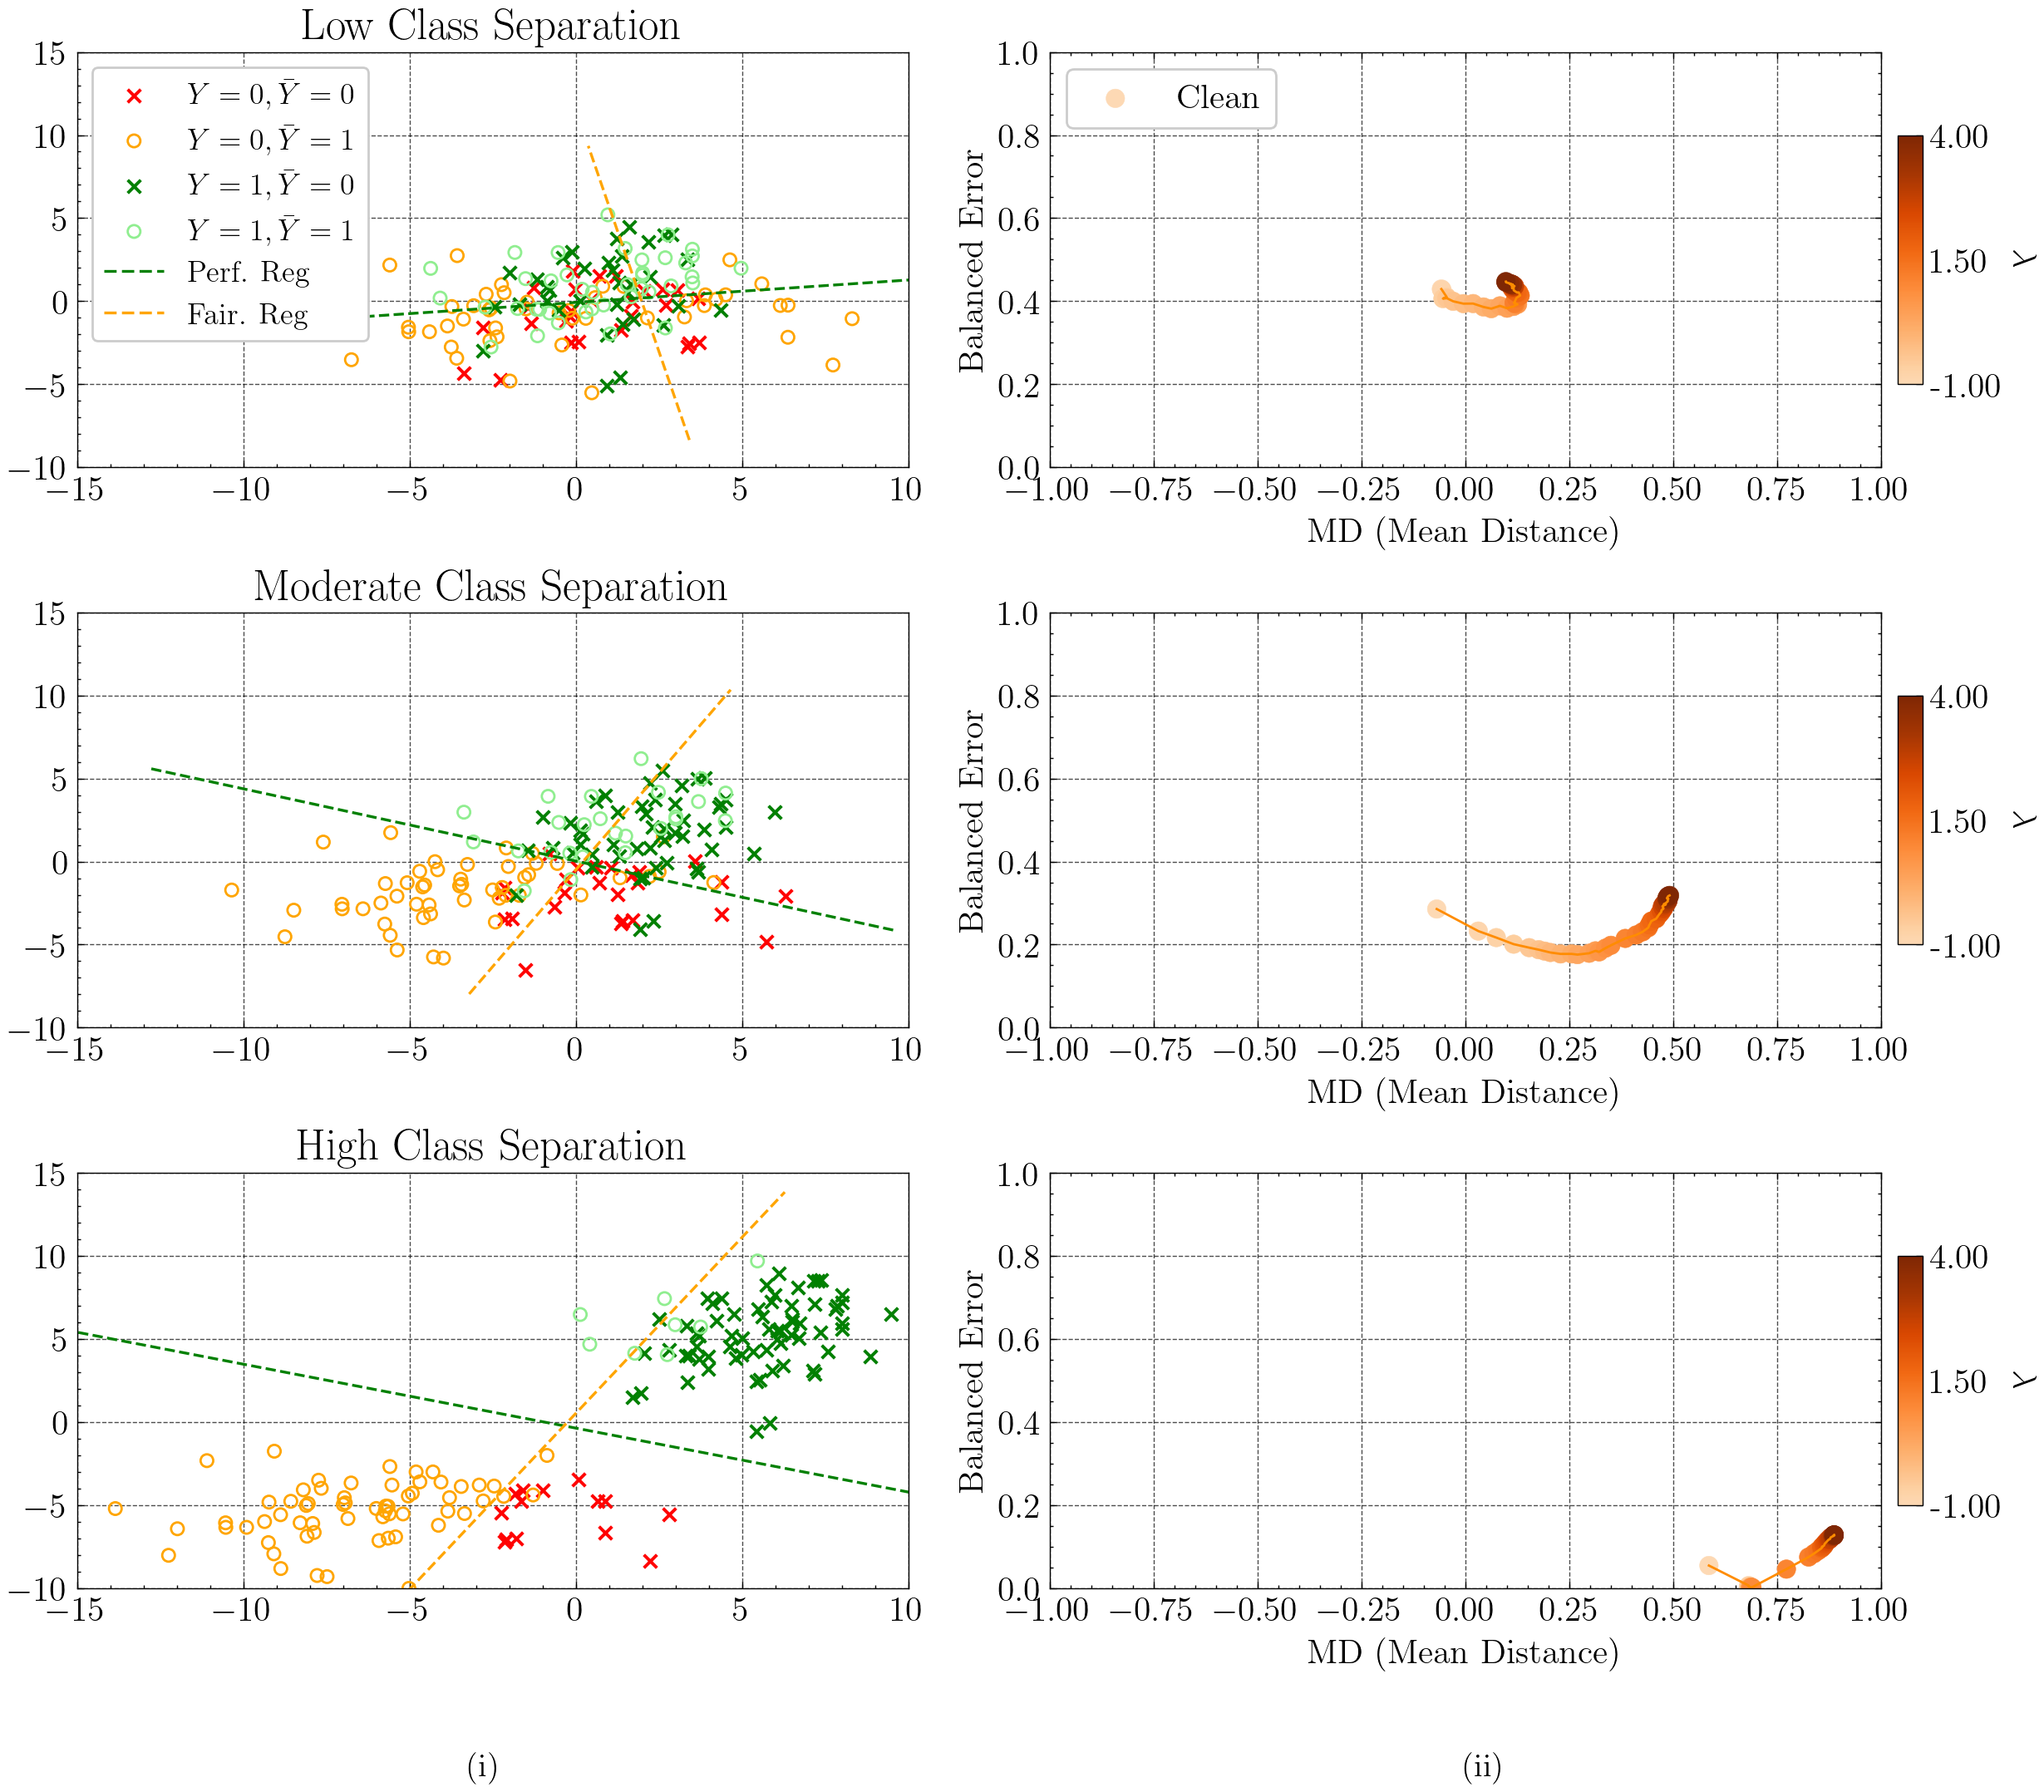

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
plt.subplots_adjust(wspace=0.17, hspace=0.35)

for row_idx, means in enumerate(mean_pairs):
    ax_left  = axes[row_idx, 0]
    ax_right = axes[row_idx, 1]
    print(means[0])
    
    X, Y, Y_sen = get_syn_data_custom(means[0], means[1], n_samples, disc_factor, rnd_seed)
    Y_corrupted = add_sym_noise(Y, flip_prob, rnd_seed)
    Y_sen_corrupted = add_sym_noise(Y_sen, 0.0, rnd_seed) #We don't need to extra corrupt the sensitive attribute, because we already corrupted the input.
    #print(np.mean(Y == 1), np.mean(Y_sen == 1))

    # Split data
    split_index = int(split_ratio * len(X))
    X_train, X_test =                   X[:split_index],            X[split_index:]
    Y_train, Y_test =                   Y[:split_index],            Y[split_index:]
    Y_corr_train, Y_corr_te1st =         Y_corrupted[:split_index],  Y_corrupted[split_index:]
    Y_sen_train, Y_sen_test =           Y_sen[:split_index],        Y_sen[split_index:]
    Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]

    #print(np.unique(X_train), np.unique(Y_train), np.unique(Y_sen_train))
    # Initialize and train models
    p_reg = LogisticRegression().fit(X_train, Y_train)
    p_reg_cor = LogisticRegression().fit(X_train, Y_corr_train)
    f_reg = LogisticRegression().fit(X_train, Y_sen_train)
    f_reg_cor = LogisticRegression().fit(X_train, Y_sen_corr_train)
    
    Y_pred = p_reg.predict(X_test)
    Y_sen_pred = f_reg.predict(X_test)
    print("iter: " + str(row_idx) + " acc p: " + str(calc_ACC(Y_pred, Y_test)))
    print("iter: " + str(row_idx) + " acc f: " + str(calc_ACC(Y_sen_pred, Y_sen_test)))
    
    plt.sca(ax_left)
    num_to_draw = 150 # we will only draw a small number of points to avoid clutter
    x_draw = X[:num_to_draw]
    y_draw = Y[:num_to_draw]
    Y_sen_draw = Y_sen[:num_to_draw]

    X_s_0 = x_draw[Y_sen_draw == 0.0] #Y=1, bar Y =1
    X_s_1 = x_draw[Y_sen_draw == 1.0] #Y=1, bar Y =1
    y_s_0 = y_draw[Y_sen_draw == 0.0] #Y=0, bar Y =0
    y_s_1 = y_draw[Y_sen_draw == 1.0] #Y=1, bar Y =1


    # Create a mesh grid of points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid_points = np.c_[xx.ravel(), yy.ravel()] #(N, 2)

    # Predict probabilities for each point on the grid
    Y_pred_p = p_reg.predict_proba(grid_points)[:, 1]
    Y_pred_p = Y_pred_p.reshape(xx.shape)

    Y_pred_f = f_reg.predict_proba(grid_points)[:, 1]
    Y_pred_f = Y_pred_f.reshape(xx.shape)

    if row_idx > 0:
        subplot_reg_without_y_pred(ax_left, Y_pred_p,Y_pred_f, xx, yy, X_s_0, y_s_0, X_s_1, y_s_1, legend_flag=False)
    else:
        subplot_reg_without_y_pred(ax_left, Y_pred_p,Y_pred_f, xx, yy, X_s_0, y_s_0, X_s_1, y_s_1)
    ax_left.set_title(dataset_titles[row_idx])

    # Sweep over lambda values and calculate metrics
    BER_list = []
    MD_list = []
    DI_list = []
    BER_list_corr = []
    MD_list_corr = []
    DI_list_corr = []

    # lmd = how important is fairness
    for lmd in lmd_interval:
        # Calculate 's' for each lambda
        s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

        # Apply step function H_a(z) with a = 0
        Y_pred = np.where(s > 0, 1, 0)
        BER = calc_BER(Y_pred, Y_test)
        MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
        DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
        BER_list.append(BER)
        MD_list.append(MD)
        DI_list.append(DI)


    # Compute now with Corrupted labels
    for lmd in lmd_interval:
        # Calculate 's' for each lambda
        s_2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg_cor.predict_proba(X_test)[:, 1] - c_bar)

        # Apply step function H_a(z) with a = 0
        Y_pred_2 = np.where(s_2 > 0, 1, 0)

        BER_2 = calc_BER(Y_pred_2, Y_test)
        MD_2 = calc_MD(Y_pred_2, Y_sen_test, symmetric_fairness)
        DI_2 = calc_DI(Y_pred_2, Y_sen_test, symmetric_fairness)
        
        BER_list_corr.append(BER_2)
        MD_list_corr.append(MD_2)
        DI_list_corr.append(DI_2)
        
    results = pd.DataFrame({
        'lambda': lmd_interval,
        'BER_clean': BER_list,
        'MD_clean': MD_list,
        'DI_clean': DI_list,
        'BER_corr': BER_list_corr,
        'MD_corr': MD_list_corr,
        'DI_corr': DI_list_corr
    })
    
            # Instead of fig = science_fig()
    ax = ax_right   # <- your subplot axes
    ax_right.set_title(pareto_titles[row_idx])
    df = results
    df = results.sort_values(by="lambda")


    # Single colormap (orange in this case)
    orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)

    # Plot line for clean results
    ax.plot(df["MD_clean"], df["BER_clean"],
            color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

    # Scatter for clean results
    sc = ax.scatter(df["MD_clean"], df["BER_clean"], 
                    c=df["lambda"], cmap=orange_cmap,
                    label="Clean", linewidths=0.2, s=65)

    # Add colorbar
    cax = inset_axes(ax,
                    width="3%",
                    height="60%",
                    loc='center right',
                    bbox_to_anchor=(0.05, 0, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)

    cbar = ax.figure.colorbar(sc, cax=cax, orientation='vertical')
    cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)

    lambda_min, lambda_max = df["lambda"].min(), df["lambda"].max()

    # Choose how many ticks you want (e.g. 5 evenly spaced)
    all_ticks = np.linspace(lambda_min, lambda_max, 3)
    all_ticklabels = [f"{v:.2f}" for v in all_ticks]

    cbar.set_ticks(all_ticks)
    cbar.set_ticklabels(all_ticklabels)

    # Labels and formatting
    ax.set_xlabel("MD (Mean Distance)", fontsize=15)
    ax.set_ylabel("Balanced Error", fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1)
    
    if row_idx == 0:
        ax.legend(loc=2, fontsize=15)


fig.canvas.draw()  # make sure positions are up to date

# Add column labels (i) and (ii) below the axes
fig.text(0.30, 0.02, "(i)", ha="center", va="center", fontsize=14)  # left column
fig.text(0.73, 0.02, "(ii)", ha="center", va="center", fontsize=14)
    
    

In [4]:
results

,lambda,BER_clean,MD_clean,DI_clean,BER_corr,MD_corr,DI_corr
0,-1.000000,0.054252,0.586397,4.584270,0.742827,-0.776228,0.114742
1,-0.871795,0.005861,0.682344,6.710694,0.463754,-0.216732,0.609595
2,-0.743590,0.004184,0.682030,6.621582,0.183775,0.345768,2.424982
3,-0.615385,0.003345,0.683555,6.634146,0.065236,0.572140,4.842517
4,-0.487179,0.002506,0.685079,6.646711,0.028468,0.643293,6.146341
5,-0.358974,0.001667,0.686603,6.659276,0.013378,0.667683,6.341463
6,-0.230769,0.001667,0.686603,6.659276,0.006700,0.680820,6.697936
7,-0.102564,0.001667,0.686603,6.659276,0.004184,0.685393,6.736210
8,0.025641,0.001667,0.686603,6.659276,0.000839,0.688442,6.761726
9,0.153846,0.001667,0.686603,6.659276,0.000839,0.688442,6.761726


In [5]:
print(len(Y_sen_test))
np.sum(Y_test == Y_sen_test)

1200


190

In [6]:
# Calculate 's' for each lambda
lmd =1.1
s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

# Apply step function H_a(z) with a = 0
Y_pred = np.where(s > 0, 1, 0)
BER = calc_BER(Y_pred, Y_test)
MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
BER_list.append(BER)
MD_list.append(MD)
DI_list.append(DI)

TP, TN, FP, FN, FPR, FNR = calc_confusion_matrix(Y_pred, Y_test)
print(FPR, FNR)

0.09105960264900662 0.020134228187919462


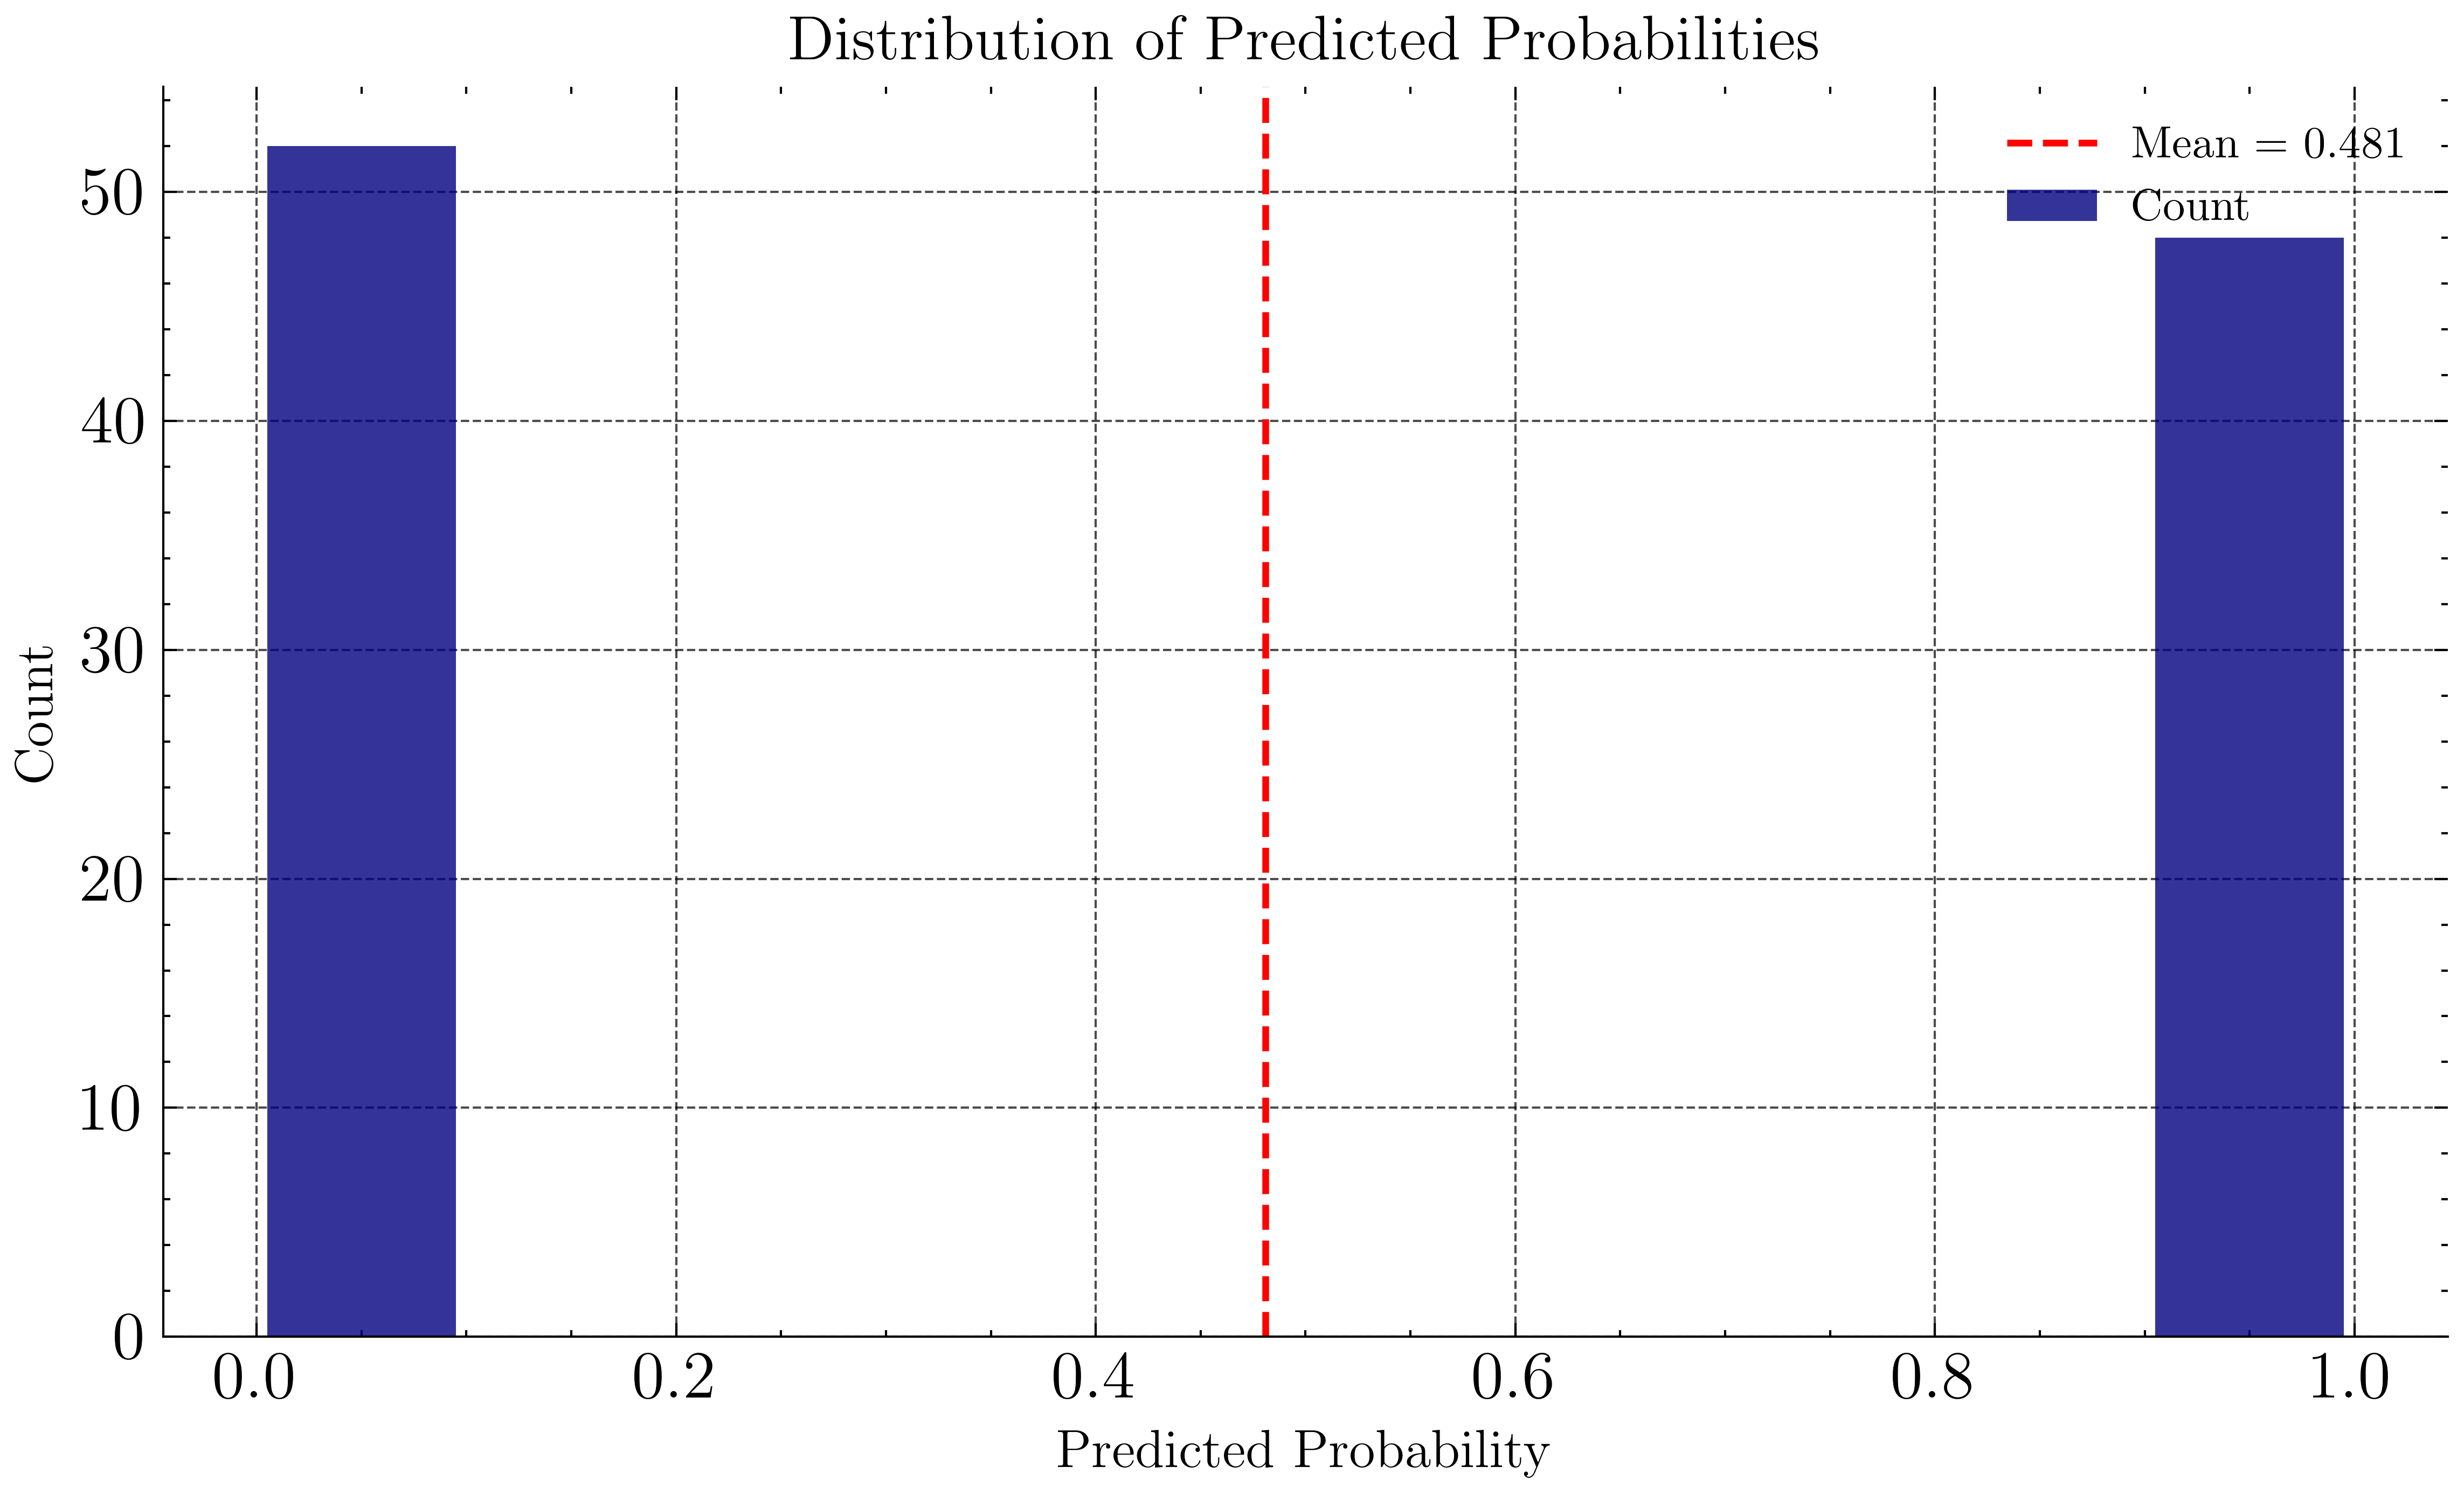

In [7]:
arr = p_reg.predict_proba(X_test[:100])[:, 1]
mean_val = arr.mean()

# Define bins
bins = np.arange(0, 1.1, 0.1)  # 0 to 1 in steps of 0.1

# Histogram
counts, edges = np.histogram(arr, bins=bins)

# Midpoints for plotting
bin_centers = (edges[:-1] + edges[1:]) / 2

# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.bar(bin_centers, counts, width=0.09, color='navy', alpha=0.8, label='Count')
ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean = {mean_val:.3f}')

ax.set_xlabel("Predicted Probability", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of Predicted Probabilities", fontsize=14)

ax.legend(frameon=False, fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

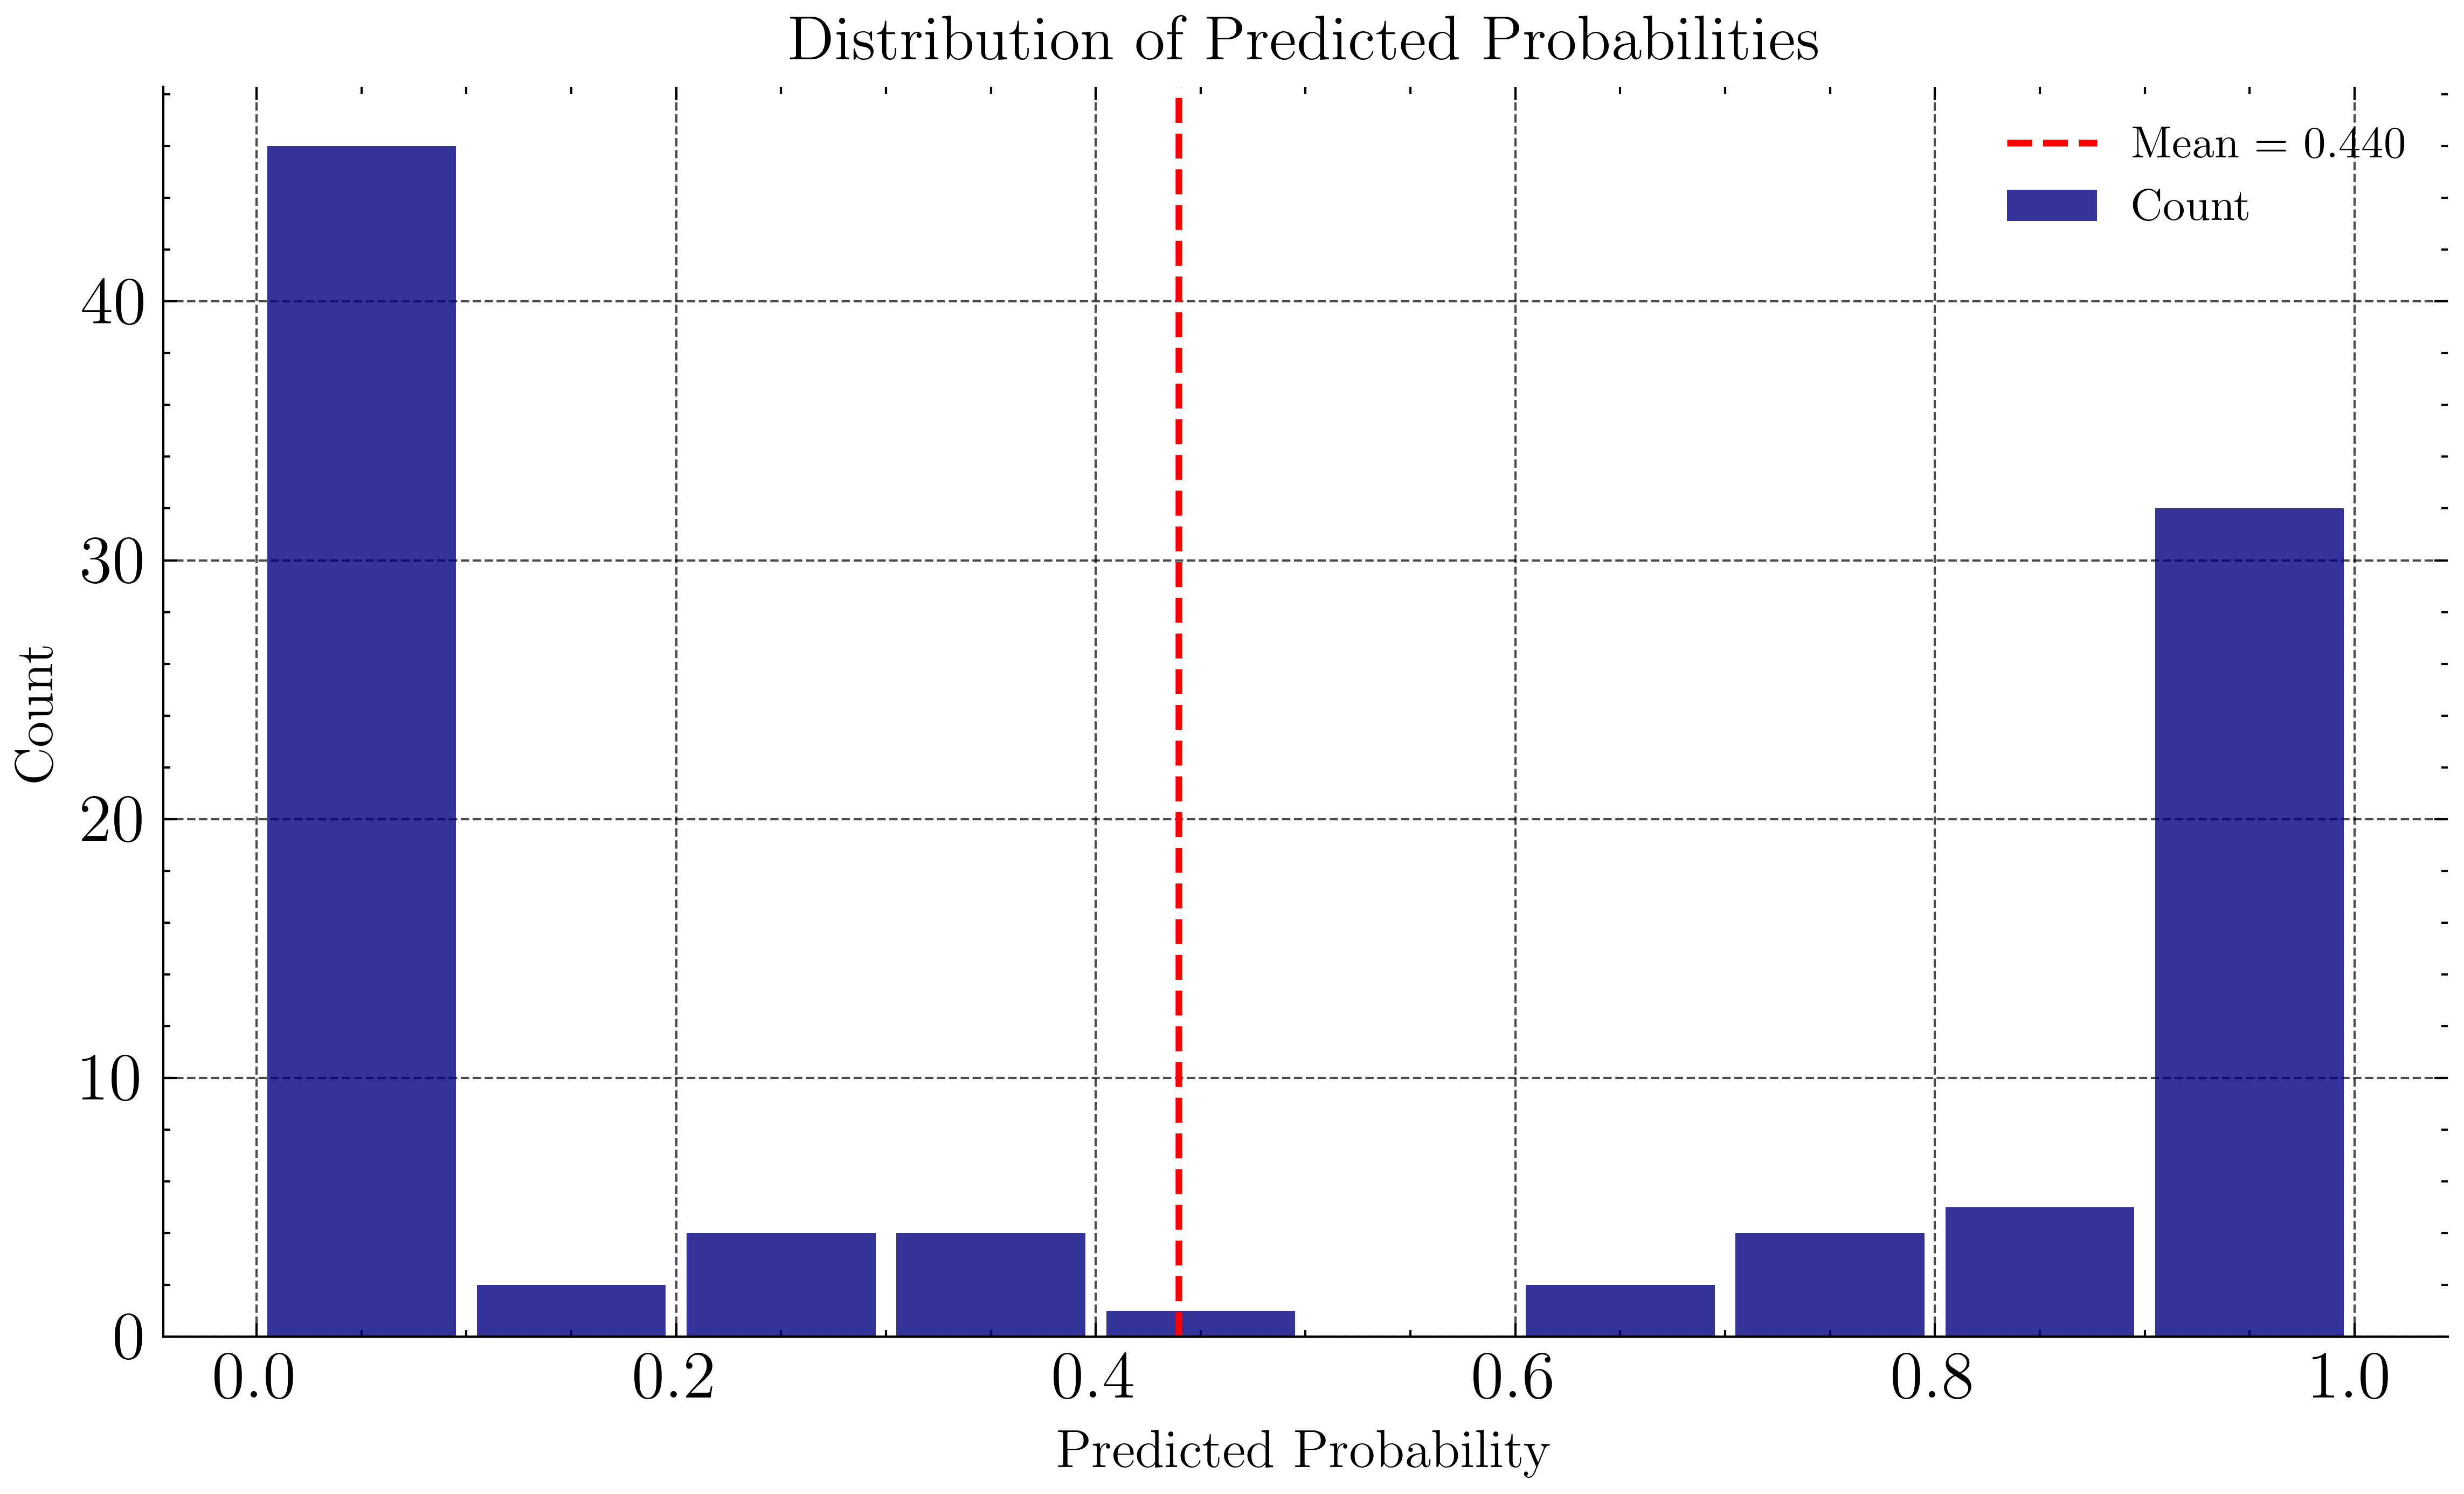

In [8]:
arr = f_reg.predict_proba(X_test[:100])[:, 1]
mean_val = arr.mean()

# Define bins
bins = np.arange(0, 1.1, 0.1)  # 0 to 1 in steps of 0.1

# Histogram
counts, edges = np.histogram(arr, bins=bins)

# Midpoints for plotting
bin_centers = (edges[:-1] + edges[1:]) / 2

# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.bar(bin_centers, counts, width=0.09, color='navy', alpha=0.8, label='Count')
ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean = {mean_val:.3f}')

ax.set_xlabel("Predicted Probability", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of Predicted Probabilities", fontsize=14)

ax.legend(frameon=False, fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 7. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
